# On Decision Trees

In [1]:
# You may need to run the following bash commands in order to
# make sure you have the relevant packages installed.

!brew install graphviz
!conda install -c pyetras pydot2

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 5 taps (homebrew/cask-versions, homebrew/core, homebrew/cask, homebrew/services and mongodb/brew).
==> New Formulae
abseil                                   libdeflate
archiver                                 libfido2
awscli@1                                 literate-git
azcopy                                   mockolo
bic                                      mtoc
biosig                                   newrelic-cli
bnfc                                     openlibm
cacli                                    polynote
cargo-instruments                        protoc-gen-grpc-web
cassandra-cpp-driver                     publish
container-structure-test                 pueue
dhall-yaml                               qp
forcecli                                 raxml-ng
gh                                       ruby@2.6
git-trim                                 seal
go@1.13                                  swift-format
hdf5@1.10             

In [2]:
import pandas as pd
from math import log
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Let's do a simple internet image search for decision trees.

What does this have to do with a data science predictive model?

A decision tree is a machine learning model that works by *partitioning* our sample space in a hierarchical way.

*How* do we partition the space? The key idea is that some attributes provide more *information* than others when trying to make a decision.

## Motivating Example

Suppose a friend said to you: "Hey, you have experience predicting housing prices! I'm hoping you can predict what my house will sell for."

What are the top questions you would ask about your friend's house? Let's make a list:

Now: *Why* are these questions good questions?

## A Bit More Detail

Suppose that we work for a retail company and that we're working on a classification model that can predict whether customers will pay their bills or not. In effect what we want to do is to ask questions that will *sort* our customers into two classes: (i) those who pay and (ii) those who don't.

(Can you think of any ethical issues that could arise here?)

**If I ask enough data-dividing questions, I can produce a partition of my data such that, in each subset, either (i) everyone is a payer or (ii) everyone is a non-payer.**

Each row in my dataframe represents a customer, and I have many predictors (columns) in my dataframe, including:

- salary
- total_bill
- club_member (boolean)
- age

Let's look at a simple set of data. **The 'paid' column is our target or dependent variable.**

In [4]:
custs = pd.DataFrame([[45000, 1000, True, 20, False],
                      [70000, 100, True, 50, True],
             [30000, 2000, False, 25, False],
                      [90000, 500, True, 44, True],
             [70000, 200, True, 48, False]],
            columns=['salary', 'total_bill', 'club_member',
                     'age', 'paid'])
custs

,salary,total_bill,club_member,age,paid
0,45000,1000,True,20,False
1,70000,100,True,50,True
2,30000,2000,False,25,False
3,90000,500,True,44,True
4,70000,200,True,48,False


## Partitioning

I partition my data by asking a question about the independent variables. The goal is to ask the right questions in the right order so that the resultant groups are "pure" with respect to the dependent variable. More on this below!

Suppose, for example, that I choose:

### Is the customer a club member?

This would divide my data into two groups:

- Group 1 (club_member = True):

data points: 0, 1, 3, 4

- Group 2 (club_member = False):

data points: 2

#### Key Question: How are the values of the target distributed in this group?
In Group 1, I have, in order: non-payer, payer, payer, non-payer.

In Group 2, I have a single non-payer.

While I've isolated one of the customers who haven't paid in the second group, the first group is an even mix of payers and non-payers. So this split is not particularly good.

Would a different question split our data more effectively? Let's try:

### "Is the customer's salary less than $60k?"

This would divide my data into two groups:

- Group 1 (salary < 60000):

data points: 0, 2

-  Group 2 (salary $\geq$ 60000):

data points: 1, 3, 4

#### Key Question: How are the values of the target distributed in this group?
In Group 1, I have two non-payers.

In Group 2, I have, in order: payer, payer, non-payer.

This does a better job of partitioning my data according to the values of the dependent variable: The first group contains only customers who have not paid their bills, and the second group contains only one customer who has not paid her bill.

So a (very simple!) model that predicts:
(i) that customers who make less than \$60k *won't* pay their bill, and
(ii) that customers who make \$60k or more *will* pay their bill

would perform fairly well.

But how would my partition be *best* split? And how do I really know that the second split is better than the first? Can I do better than intuition here?

## Entropy and Information Gain

The goal is to have our ultimate classes be fully "ordered" (for a binary dependent variable, we'd have the 1's in one group and the 0's in the other). So one way to assess the value of a split is to measure how *disordered* our groups are, and there is a notion of *entropy* that measures precisely this.

The entropy of the whole dataset is given by:

$\large E = -\Sigma^n_i p_i\log_2(p_i)$,

where $p_i$ is the probability of belonging to the $i$th group, where $n$ is the number of groups (i.e. target values).

**Entropy will always be between 0 and 1. The closer to 1, the more disordered your group.**

To repeat, in the present case we have only two groups of interest: the payers and the non-payers.

Two out of five are payers and three out of five are non-payers, so **these are the relevant probabilities** for our calculation of entropy.

So our entropy for this toy dataset is:

$-0.4*\log_2(0.4) -0.6*\log_2(0.6)$.

Let's use the ```math``` library's `log()` function to calculate this:

In [13]:
# Your code here!
ent_whole = -0.5*log(0.5, 2) - 0.5*log(0.5, 2)
ent_whole


1.0

That's pretty disordered!

To calculate the entropy of a *split*, we're going to want to calculate the entropy of each of the groups made by the split, and then calculate a weighted average of those groups' entropies––weighted, that is, by the size of the groups. Let's calculate the entropy of the split produced by our question above about salary:

Group 1:

$E_{g1} = - 1 * \log_2(1) = 0$. This is a pure group! The probability of being a payer in Group 1 is 0 and the probability of being a non-payer in Group 1 is 1.

Group 2:

$E_{g2} = -\frac{2}{3} * \log_2\left(\frac{2}{3}\right) - \frac{1}{3} * \log_2\left(\frac{1}{3}\right)$.

Once again, using ```math```:

In [15]:
# Your code here!
ent_grp1 = -1*log(1,2)
ent_grp1

ent_grp2 = -2/3*log(2/3, 2) - 1/3*log(1/3, 2)
ent_grp2

0.9182958340544896

To get the whole entropy for this split, we'll do a weighted sum of the two group entropies:

In [16]:
# Your code here!
0.4*ent_grp1 + 0.6*ent_grp2


0.5509775004326937

For a given split, the **information gain** is simply the entropy of the parent group less the entropy of the split.

For a given parent, then, we maximize our model's performance by *minimizing* the split's entropy.

What we'd like to do then is:

1. to look at the entropies of all possible splits, and
2. to choose the split with the lowest entropy.

In practice there are far too many splits for it to be practical for a person to calculate all these different entropies ...

... but we can make computers do these calculations for us!

## Gini Impurity

An alternative metric to entropy comes from the work of Corrado Gini. The Gini Impurity is defined as:

$\large G = 1 - \Sigma_ip_i^2$, or, equivalently, $\large G = \Sigma_ip_i(1-p_i)$.

where, again, $p_i$ is the probability of belonging to the $i$th group.

**Gini Impurity will always be between 0 and 0.5. The closer to 0.5, the more disordered your group.**

Exercise: Calculate the Gini Impurity for our toy dataset above.

In [17]:
# Your code here!

1 - (0.6**2 + 0.4**2)

0.48

## Coding Trees in Python

Scikit-learn has a tree module, which houses both a DecisionTreeClassifier and a DecisionTreeRegressor. As is probably clear by now, the former is for classification problems (discrete target) and the latter is for regression problems (continuous target). Let's use the classifier.

(How does the regressor work? Information gain and Gini impurity make sense only for discrete classes. What we need for a continuous target is some measure of the *spread* of those values, and so the natural move here is to split our groups in ways that will most *reduce the standard deviation of those groups*. For more on this, see [here](https://www.saedsayad.com/decision_tree_reg.htm).)

In [18]:
ct = DecisionTreeClassifier(criterion='entropy', random_state=1)    # Check out all the
                                                                    # hyperparameter options here!

ct.fit(custs.drop('paid', axis=1), custs['paid'])
ct.score(custs.drop('paid', axis=1), custs['paid'])

1.0

Let's visualize this!

In [19]:
n_nodes = ct.tree_.node_count
children_left = ct.tree_.children_left
children_right = ct.tree_.children_right
feature = ct.tree_.feature
threshold = ct.tree_.threshold

# This code courtesy of sklearn:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 7 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 34.5 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 0] <= 80000.0 else to node 6.
		node=3 test node: go to node 4 if X[:, 3] <= 49.0 else to node 5.
			node=4 leaf node.
			node=5 leaf node.
		node=6 leaf node.



In [20]:
# How many nodes do we have?

ct.tree_.node_count

7

In [23]:
# This tells us which node is immediately to the left of each node in our tree.

print(ct.tree_.children_left)

# This tells us which node is immediately to the right of each node in our tree.

print(ct.tree_.children_right)

[ 1 -1  3  4 -1 -1 -1]
[ 2 -1  6  5 -1 -1 -1]


## Another Visualization

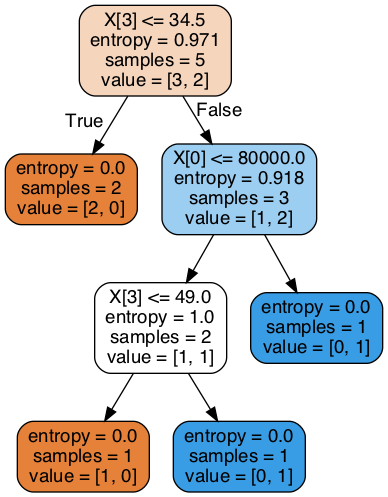

In [22]:
dot_file = StringIO()

export_graphviz(ct, out_file=dot_file, filled=True,
               rounded=True)

image=pydotplus.graph_from_dot_data(dot_file.getvalue())
Image(image.create_png())

## Interpretation

Let's unpack this:

- The first question ("test") is: "Is Age $\leq$ 34.5?" If so, then stop: All such customers (i.e. customers 0 and 2) are *non-payers*. Notice how 34.5 is midway between the ages of customer 2 (25), a non-payer and customer 3 (44), a payer).

- If not: The next test (for those whose age > 34.5) is: "Is Salary $\leq$ 80000?" If not, then stop: All such customers (i.e. customer 3) are *payers*. Notice how 80000 is midway between the salaries of customer 3 (90000, a payer) and customer 4 (70000, a non-payer).

- If so: The next test (for those whose salary $\leq$ 80000) is: "Is Age $\leq$ 49.0?" If so, then stop: All such customers (i.e. customer 4) are *non-payers*. If not, then stop: All such customers (i.e. customer 1) are *payers*. Notice how 49.0 is midway between the ages of customer 1 (50, a payer) and customer 4 (48, a non-payer).

## Feature Importances

The fitted tree has an attribute called `ct.feature_importances_`. What does this mean? Roughly, the importance (or "Gini importance") of a feature is a sort of weighted average of the impurity decrease at internal nodes that make use of the feature. The weighting comes from the number of samples that depend on the relevant nodes.

In [24]:
ct.feature_importances_

array([0.15549452, 0.        , 0.        , 0.84450548])

Let's see if we can calculate these by hand:

In [25]:
# Entropies at Internal Nodes:
n0_ent = -(0.6 * log(0.6, 2) + 0.4 * log(0.4, 2))
n2_ent = -((2/3) * log((2/3), 2) + (1/3) * log((1/3), 2))
n3_ent = -(0.5 * log(0.5, 2) + 0.5 * log(0.5, 2))

# Node Importances
n0_imp = n0_ent - 0.6 * n2_ent
n2_imp = 0.6 * n2_ent - 0.4 * n3_ent
n3_imp = 0.4 * n3_ent

In [26]:
n_imp_sum = n0_imp + n2_imp + n3_imp

In [27]:
n2_imp / n_imp_sum

0.15549452391806784

In [28]:
(n0_imp + n3_imp) / n_imp_sum

0.8445054760819322

See [here](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3) for more on feature importances.

## Practice on a Larger Dataset

Exercise: Use a tree for prediction. Using the data below, use height and weight to predict gender.

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
wts_hts = pd.read_csv('weight-height.csv')

In [ ]:
# Your code here







In [10]:
X = np.arange(1,101)
y = np.arange(5,105)
train, test = X[:60], X[60:]
y_preds = []
for pt in test:
    dist = abs(X[0] - pt)
#     print(dist)
    label = y[0]
    for j in range(1, 60):
        if abs(X[j] - pt) < dist:
            label = y[j]
    print(label)
    y_preds.append(label)
sum(abs(y_preds - y[60:]))


64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64


820